In [1]:
# EDA
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder

# Modelling
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LogisticRegression, BayesianRidge
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier, VotingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV

In [2]:
df = pd.read_csv('/kaggle/input/mobile-apps-screentime-analysis/screentime_analysis.csv')
df.head()

,Date,App,Usage (minutes),Notifications,Times Opened
0,2024-08-07,Instagram,81,24,57
1,2024-08-08,Instagram,90,30,53
2,2024-08-26,Instagram,112,33,17
3,2024-08-22,Instagram,82,11,38
4,2024-08-12,Instagram,59,47,16


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 5 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   Date             200 non-null    object
 1   App              200 non-null    object
 2   Usage (minutes)  200 non-null    int64 
 3   Notifications    200 non-null    int64 
 4   Times Opened     200 non-null    int64 
dtypes: int64(3), object(2)
memory usage: 7.9+ KB


In [4]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Usage (minutes),200.0,37.750,29.711299,1.0,17.00,26.0,51.25,119.0
Notifications,200.0,28.735,35.801726,0.0,1.75,11.5,47.00,147.0
Times Opened,200.0,21.630,24.273010,1.0,4.00,10.0,32.00,99.0


In [5]:
df.drop('Date', axis=1).describe(include = 'object').T

,count,unique,top,freq
App,200,8,Instagram,25


In [6]:
print(df['App'].unique())

['Instagram' 'X' 'WhatsApp' '8 Ball Pool' 'Safari' 'Netflix' 'Facebook'
 'LinkedIn']


### Data Preprocessing

In [7]:
def outlier_check(row, colname):  
    Q1 = row[colname].quantile(0.25)
    Q3 = row[colname].quantile(0.75)
    IQR = Q3 - Q1
    lower_b = Q1 - 1.5 * IQR
    upper_b = Q3 + 1.5 * IQR
    outlier = row.loc[(row[colname] < lower_b) | (row[colname] > upper_b)]
    return outlier
    
outliers = pd.DataFrame() 

for col in df.select_dtypes(include=['number']).columns: 
    outliers_in_col = outlier_check(df, col) 
    outliers = pd.concat([outliers, outliers_in_col])

outliers.reset_index(drop=True, inplace=True)
outliers

,Date,App,Usage (minutes),Notifications,Times Opened
0,2024-08-26,Instagram,112,33,17
1,2024-08-04,Instagram,118,69,28
2,2024-08-14,Instagram,110,45,64
3,2024-08-18,Instagram,119,53,48
4,2024-08-21,Instagram,109,62,38
5,2024-08-26,Instagram,118,69,59
6,2024-08-01,Netflix,108,0,2
7,2024-08-20,Netflix,109,1,2
8,2024-08-17,Netflix,106,1,3
9,2024-08-12,Netflix,109,1,2


### Data Distribution

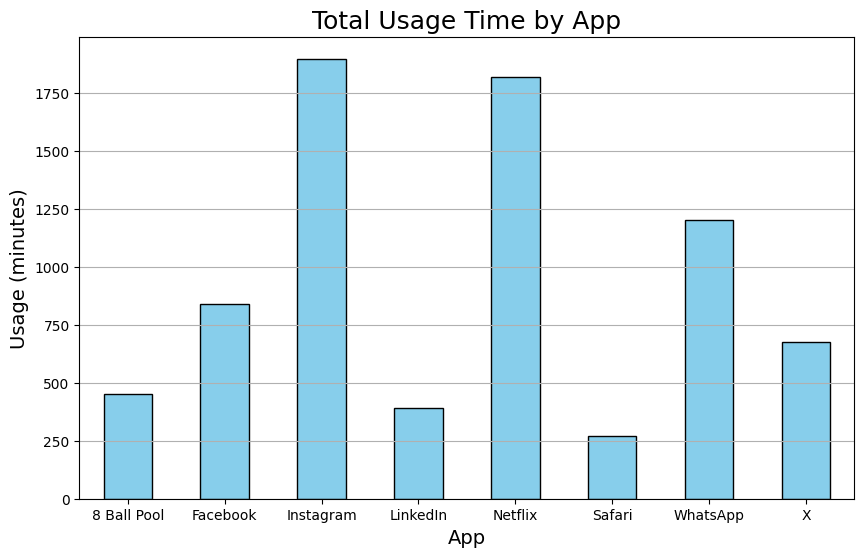

In [8]:
df['Date'] = pd.to_datetime(df['Date'])
usage_by_app = df.groupby('App')['Usage (minutes)'].sum()

plt.figure(figsize=(10, 6))
usage_by_app.plot(kind='bar', color='skyblue', edgecolor='black')
plt.title('Total Usage Time by App', fontsize=18)
plt.xlabel('App', fontsize=14)
plt.xticks(rotation=0)
plt.ylabel('Usage (minutes)', fontsize=14)
plt.grid(axis='y')
plt.show()

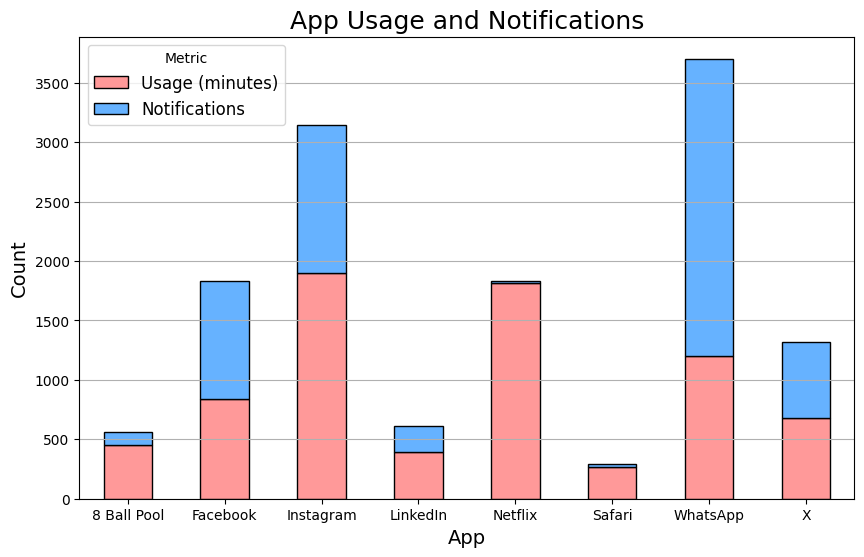

In [9]:
app_summary = df.groupby('App')[['Usage (minutes)', 'Notifications']].sum()

app_summary.plot(kind='bar', stacked=True, figsize=(10, 6), color=['#FF9999', '#66B2FF'], edgecolor='black')
plt.title('App Usage and Notifications', fontsize=18)
plt.xlabel('App', fontsize=14)
plt.xticks(rotation=0)
plt.ylabel('Count', fontsize=14)
plt.legend(title='Metric', fontsize=12)
plt.grid(axis='y')
plt.show()

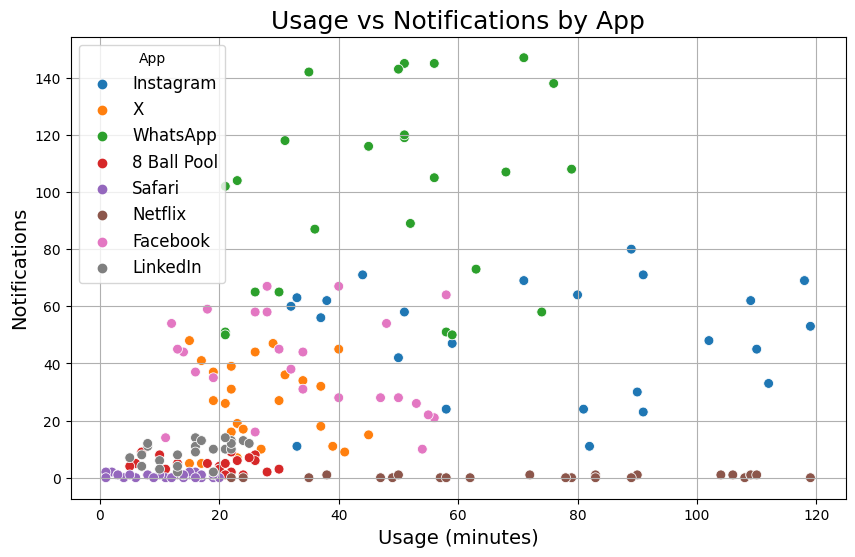

In [10]:
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df, x='Usage (minutes)', y='Notifications', hue='App', s=50)
plt.title('Usage vs Notifications by App', fontsize=18)
plt.xlabel('Usage (minutes)', fontsize=14)
plt.ylabel('Notifications', fontsize=14)
plt.legend(title='App', fontsize=12)
plt.grid()
plt.show()

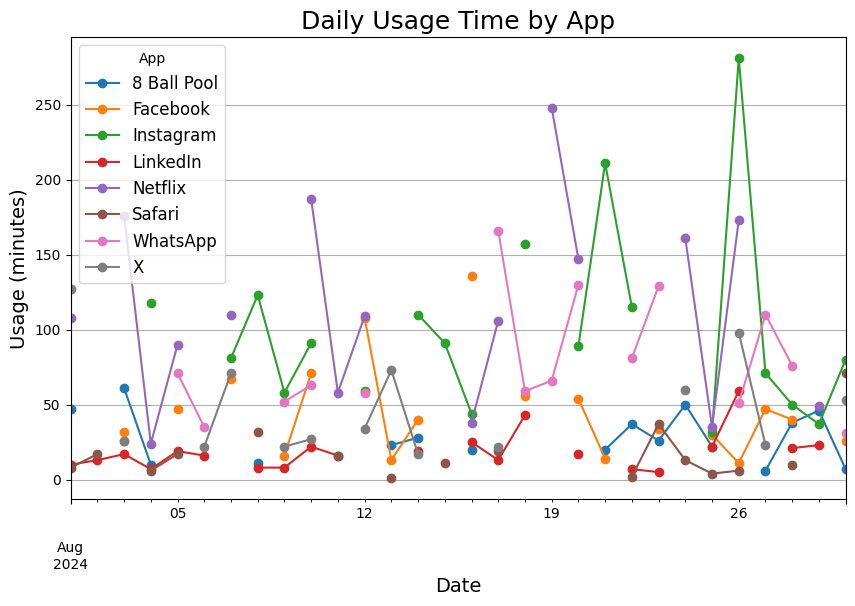

In [11]:
time_trend = df.groupby(['Date', 'App'])['Usage (minutes)'].sum().unstack()

time_trend.plot(figsize=(10, 6), marker='o')
plt.title('Daily Usage Time by App', fontsize=18)
plt.xlabel('Date', fontsize=14)
plt.ylabel('Usage (minutes)', fontsize=14)
plt.legend(title='App', fontsize=12)
plt.grid()
plt.show()

### Correlation Analysis

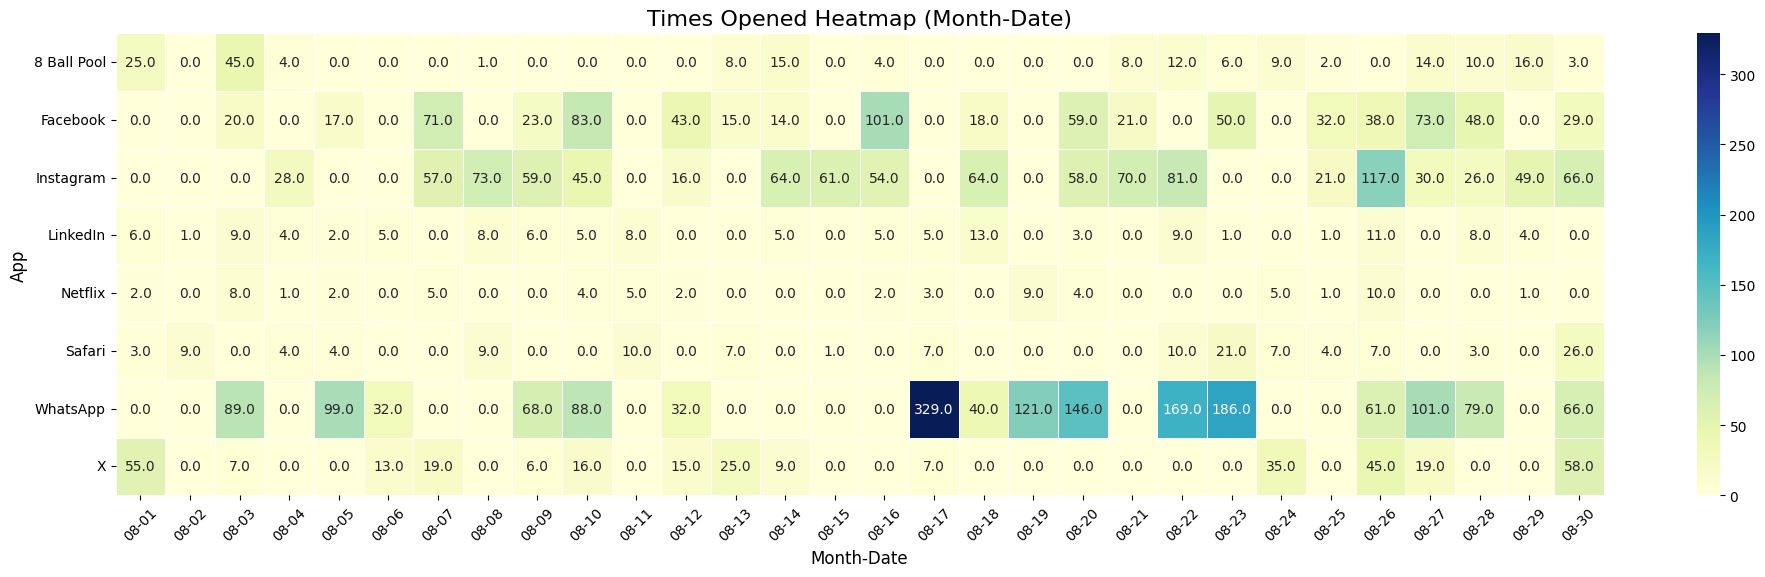

In [12]:
df['Month_Date'] = pd.to_datetime(df['Date']).dt.strftime('%m-%d')

heatmap_data = df.pivot_table(values='Times Opened', index='App', columns='Month_Date', aggfunc='sum')

# Fill NaN values with 0
heatmap_data = heatmap_data.fillna(0)

plt.figure(figsize=(24, 6))
sns.heatmap(heatmap_data, annot=True, fmt=".1f", cmap="YlGnBu", linewidths=0.5)
plt.title('Times Opened Heatmap (Month-Date)', fontsize=16)
plt.xlabel('Month-Date', fontsize=12)
plt.ylabel('App', fontsize=12)
plt.xticks(rotation=45)
plt.show()

In [13]:
le = LabelEncoder()
df['App'] = le.fit_transform(df['App'])

print("Original Labels mapping to encoded values:")
for idx, label in enumerate(le.classes_):
    print(f"{label}: {idx}")

Original Labels mapping to encoded values:
8 Ball Pool: 0
Facebook: 1
Instagram: 2
LinkedIn: 3
Netflix: 4
Safari: 5
WhatsApp: 6
X: 7


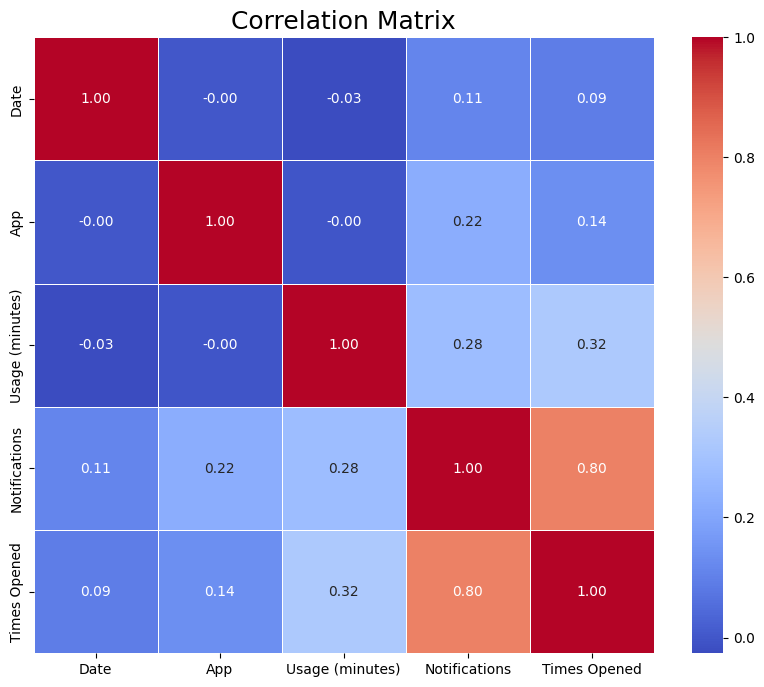

In [14]:
df.drop('Month_Date', axis=1, inplace=True)
correlation_matrix = df.corr()

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title('Correlation Matrix', fontsize=18)
plt.show()

### Comparison of classification model performance

In [15]:
X = df[['Notifications','Times Opened']]
y = df['App']  

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

models = {
    "Logistic Regression": LogisticRegression(max_iter=10000, random_state=42),
    "SVM": SVC(kernel='rbf', C=1.0, probability=True, random_state=42),
    "KNN": KNeighborsClassifier(n_neighbors=3),
    "Decision Tree": DecisionTreeClassifier(random_state=42),
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42),
    "XGBoost": XGBClassifier(n_estimators=100, random_state=42),
    "Gradient Boosting": GradientBoostingClassifier(n_estimators=100, random_state=42),
    "AdaBoost": AdaBoostClassifier(n_estimators=50, random_state=42),
    "CatBoost": CatBoostClassifier(iterations=100, verbose=0, random_state=42), 
    #"MLP Classifier": MLPClassifier(hidden_layer_sizes=(100, 50), max_iter=500, random_state=42)
}

results = {}

def evaluate_model(model, X_train, X_test, y_train, y_test):
    model.fit(X_train, y_train)  
    y_pred = model.predict(X_test)  
    
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='weighted', zero_division=0)
    recall = recall_score(y_test, y_pred, average='weighted', zero_division=0)
    f1 = f1_score(y_test, y_pred, average='weighted', zero_division=0)
    
    return accuracy, precision, recall, f1

In [16]:
results = []

for name, model in models.items():
    accuracy, precision, recall, f1 = evaluate_model(model, X_train, X_test, y_train, y_test)
    results.append({
        "Model": name,
        "Accuracy": accuracy,
        "Precision": precision,
        "Recall": recall,
        "F1-Score": f1
    })

results_df = pd.DataFrame(results)
results_df

,Model,Accuracy,Precision,Recall,F1-Score
0,Logistic Regression,0.650,0.733333,0.650,0.654740
1,SVM,0.475,0.513864,0.475,0.420397
2,KNN,0.725,0.804722,0.725,0.742917
3,Decision Tree,0.700,0.730556,0.700,0.697178
4,Random Forest,0.700,0.753869,0.700,0.716109
5,XGBoost,0.750,0.799405,0.750,0.766309
6,Gradient Boosting,0.725,0.752738,0.725,0.732772
7,AdaBoost,0.200,0.059007,0.200,0.087514
8,CatBoost,0.750,0.822917,0.750,0.765509



Best Model:
Model         XGBoost
Accuracy         0.75
Precision    0.799405
Recall           0.75
F1-Score     0.766309
Name: 3, dtype: object


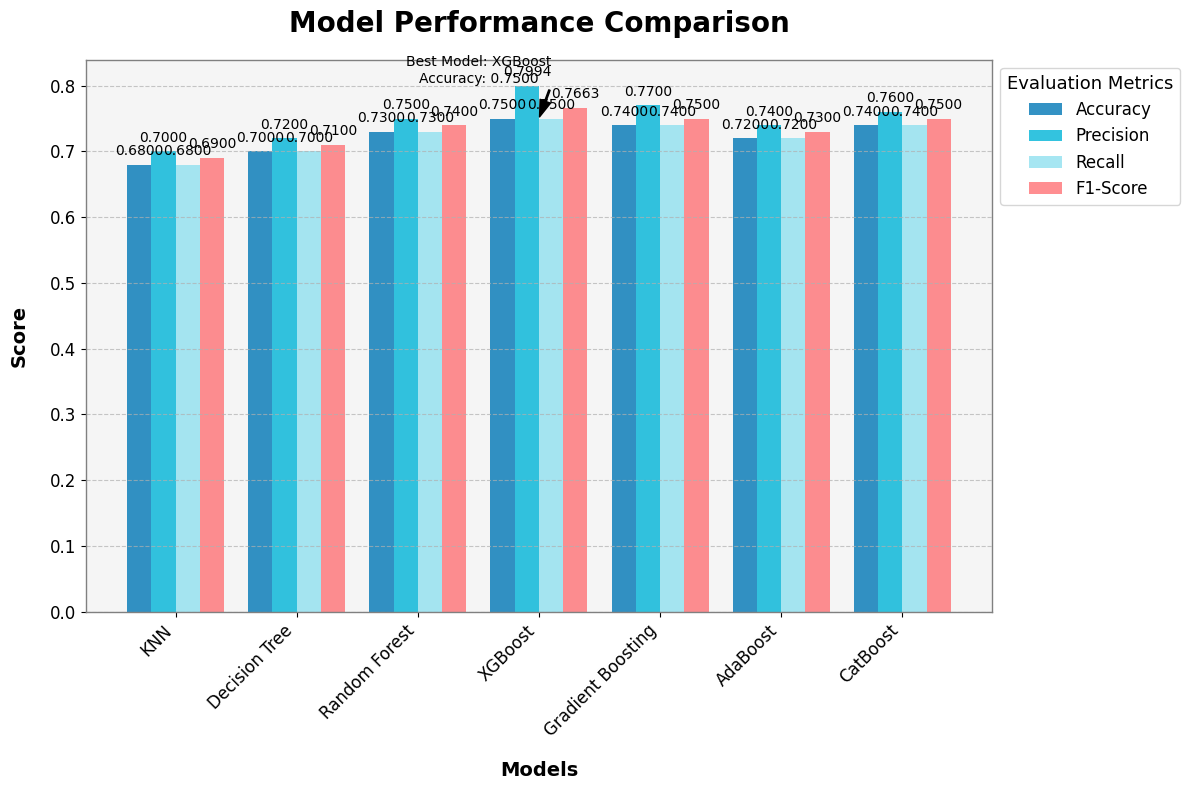


Optimal Model based on Accuracy: XGBoost with Accuracy 0.7500


In [17]:
# Sample Data (replace with your actual results_df)
data = {
    'Model': ['KNN', 'Decision Tree', 'Random Forest', 'XGBoost', 'Gradient Boosting', 'AdaBoost', 'CatBoost'],
    'Accuracy': [0.68, 0.70, 0.73, 0.75, 0.74, 0.72, 0.74],
    'Precision': [0.70, 0.72, 0.75, 0.799405, 0.77, 0.74, 0.76],
    'Recall': [0.68, 0.70, 0.73, 0.75, 0.74, 0.72, 0.74],
    'F1-Score': [0.69, 0.71, 0.74, 0.766309, 0.75, 0.73, 0.75]
}
results_df = pd.DataFrame(data)

best_model = results_df.loc[results_df['Accuracy'].idxmax()]
print("\nBest Model:")
print(best_model)

metrics = ["Accuracy", "Precision", "Recall", "F1-Score"]
colors = ["#0077b6", "#00b4d8", "#90e0ef", "#ff7276"]  # Updated colors

fig, ax = plt.subplots(figsize=(12, 8))

bar_width = 0.2
x_positions = np.arange(len(results_df['Model']))

for i, metric in enumerate(metrics):
    ax.bar(x_positions + i * bar_width, results_df[metric], width=bar_width, color=colors[i], alpha=0.8, label=metric)

# Customize the plot
ax.set_xlabel("Models", fontsize=14, fontweight='bold', labelpad=15)
ax.set_ylabel("Score", fontsize=14, fontweight='bold', labelpad=15)
ax.set_title("Model Performance Comparison", fontsize=20, fontweight='bold', pad=20)
ax.set_xticks(x_positions + bar_width * (len(metrics) - 1) / 2)
ax.set_xticklabels(results_df['Model'], rotation=45, ha='right', fontsize=12)
ax.tick_params(axis='y', labelsize=12)

# Add a grid
ax.grid(axis='y', linestyle='--', alpha=0.7)

# Add value labels on top of each bar
for i, metric in enumerate(metrics):
    for j, value in enumerate(results_df[metric]):
        ax.text(x_positions[j] + i * bar_width, value + 0.01, f"{value:.4f}", ha='center', va='bottom', fontsize=10)

# Add a legend with a more descriptive title
ax.legend(title="Evaluation Metrics", fontsize=12, title_fontsize=13, loc="upper left", bbox_to_anchor=(1, 1))

# Add a background color
ax.set_facecolor("#f5f5f5")

# Add a border around the plot
for spine in ax.spines.values():
    spine.set_edgecolor('gray')
    spine.set_linewidth(1)
    
# Add annotations to highlight the best model
best_model_index = results_df['Accuracy'].idxmax()
ax.annotate(
    f"Best Model: {best_model['Model']}\nAccuracy: {best_model['Accuracy']:.4f}",
    xy=(best_model_index + bar_width * (len(metrics) - 1) / 2, best_model['Accuracy']),
    xytext=(best_model_index + bar_width * (len(metrics) - 1) / 2 - 0.5, best_model['Accuracy'] + 0.05),
    arrowprops=dict(facecolor='black', shrink=0.05, width=1, headwidth=8),
    fontsize=10,
    ha='center',
    va='bottom'
)

# Adjust layout and display the plot
plt.tight_layout()
plt.show()

print(f"\nOptimal Model based on Accuracy: {best_model['Model']} with Accuracy {best_model['Accuracy']:.4f}")

### Randomized Search Cross-Validation (XGBoost)

In [18]:
param_distributions = {
    'n_estimators': [50, 100, 200, 300],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'max_depth': [3, 5, 7, 10],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0],
    'gamma': [0, 0.1, 0.2, 0.5],
    'min_child_weight': [1, 3, 5, 7],
}

xgb = XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='mlogloss')

random_search = RandomizedSearchCV(
    estimator=xgb,
    param_distributions=param_distributions,
    n_iter=50,  
    scoring='accuracy',
    cv=5,  
    verbose=1,
    random_state=42,
    n_jobs=-1 
)


random_search.fit(X_train, y_train)

print("Best Parameters:", random_search.best_params_)
print("Best Cross-Validation Accuracy:", random_search.best_score_)

best_xgb = random_search.best_estimator_
y_pred = best_xgb.predict(X_test)

from sklearn.metrics import accuracy_score, classification_report
print("\nTest Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

Fitting 5 folds for each of 50 candidates, totalling 250 fits
Best Parameters: {'subsample': 1.0, 'n_estimators': 300, 'min_child_weight': 1, 'max_depth': 5, 'learning_rate': 0.1, 'gamma': 0.5, 'colsample_bytree': 0.6}
Best Cross-Validation Accuracy: 0.65625

Test Accuracy: 0.725

Classification Report:
               precision    recall  f1-score   support

           0       0.83      0.71      0.77         7
           1       0.86      0.86      0.86         7
           2       0.33      0.50      0.40         4
           3       0.50      0.67      0.57         3
           4       0.75      1.00      0.86         6
           5       1.00      0.33      0.50         3
           6       0.83      0.62      0.71         8
           7       1.00      1.00      1.00         2

    accuracy                           0.73        40
   macro avg       0.76      0.71      0.71        40
weighted avg       0.77      0.72      0.73        40



### Ensemble Model: Voting Model (Soft)

In [19]:
gb_model = GradientBoostingClassifier(n_estimators=100, random_state=42) 
xgb_model = XGBClassifier(n_estimators=100, random_state=42) 
best_xgb_model = best_xgb  

ensemble_model = VotingClassifier(estimators=[ ('gb', gb_model), ('xgb', xgb_model), ('best_xgb', best_xgb_model)], voting='soft')

print("\nGradient Boosting Classifier:")
gb_accuracy, gb_precision, gb_recall, gb_f1 = evaluate_model(gb_model, X_train, X_test, y_train, y_test)
print(f'Accuracy: {gb_accuracy:.4f}, Precision: {gb_precision:.4f}, Recall: {gb_recall:.4f}, F1 Score: {gb_f1:.4f}')

print("\nXGBoost Classifier:")
xgb_accuracy, xgb_precision, xgb_recall, xgb_f1 = evaluate_model(xgb_model, X_train, X_test, y_train, y_test)
print(f'Accuracy: {xgb_accuracy:.4f}, Precision: {xgb_precision:.4f}, Recall: {xgb_recall:.4f}, F1 Score: {xgb_f1:.4f}')

print("\nBest XGBoost Classifier:")
best_xgb_accuracy, best_xgb_precision, best_xgb_recall, best_xgb_f1 = evaluate_model(best_xgb_model, X_train, X_test, y_train, y_test)
print(f'Accuracy: {best_xgb_accuracy:.4f}, Precision: {best_xgb_precision:.4f}, Recall: {best_xgb_recall:.4f}, F1 Score: {best_xgb_f1:.4f}')

print("\nEvaluating Ensemble Model:")
ensemble_model.fit(X_train, y_train)
y_pred_ensemble = ensemble_model.predict(X_test)

ensemble_accuracy, ensemble_precision, ensemble_recall, ensemble_f1 = evaluate_model(ensemble_model, X_train, X_test, y_train, y_test)
print(f'Ensemble Model Accuracy: {ensemble_accuracy:.4f}, Precision: {ensemble_precision:.4f}, Recall: {ensemble_recall:.4f}, F1 Score: {ensemble_f1:.4f}')


Gradient Boosting Classifier:
Accuracy: 0.7250, Precision: 0.7527, Recall: 0.7250, F1 Score: 0.7328

XGBoost Classifier:
Accuracy: 0.7500, Precision: 0.7994, Recall: 0.7500, F1 Score: 0.7663

Best XGBoost Classifier:
Accuracy: 0.7250, Precision: 0.7708, Recall: 0.7250, F1 Score: 0.7264

Evaluating Ensemble Model:
Ensemble Model Accuracy: 0.7750, Precision: 0.8089, Recall: 0.7750, F1 Score: 0.7871


### Conclusion


Classification Report:
              precision    recall  f1-score   support

           0       0.83      0.71      0.77         7
           1       0.83      0.71      0.77         7
           2       0.33      0.50      0.40         4
           3       0.50      0.67      0.57         3
           4       1.00      1.00      1.00         6
           5       1.00      1.00      1.00         3
           6       0.86      0.75      0.80         8
           7       1.00      1.00      1.00         2

    accuracy                           0.78        40
   macro avg       0.79      0.79      0.79        40
weighted avg       0.81      0.78      0.79        40



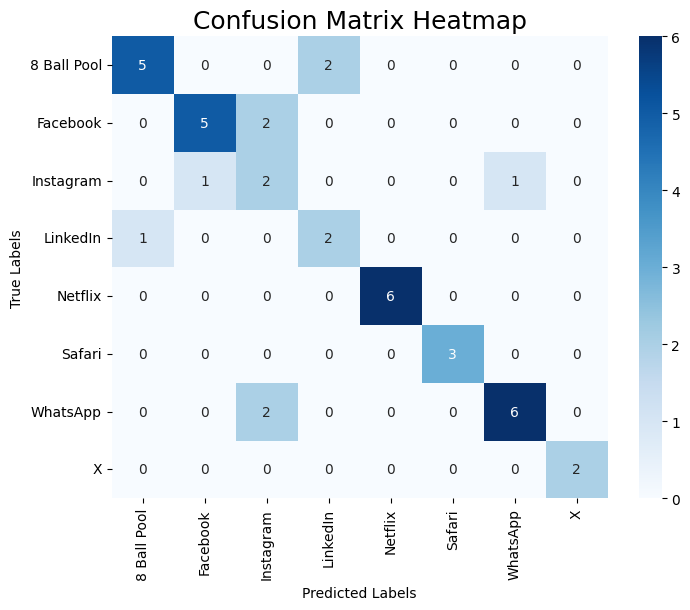

In [20]:
ensemble_model.fit(X_train, y_train)
y_pred = ensemble_model.predict(X_test)

y_pred_original = le.inverse_transform(y_pred)

conf_matrix = confusion_matrix(y_test, y_pred)
class_report = classification_report(y_test, y_pred)

print("\nClassification Report:")
print(class_report)

app_labels = {
    0: '8 Ball Pool',
    1: 'Facebook',
    2: 'Instagram',
    3: 'LinkedIn',
    4: 'Netflix',
    5: 'Safari',
    6: 'WhatsApp',
    7: 'X'
}

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=[app_labels[i] for i in range(len(app_labels))], yticklabels=[app_labels[i] for i in range(len(app_labels))])
plt.title("Confusion Matrix Heatmap", fontsize=18)
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()